<a href="https://colab.research.google.com/github/BastienBoucherat/geo6149/blob/main/geo6149_projet_bastien.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Projet: Autonomie alimentaire et territoire**
GEO-6149: Géomatique

*   Bastien Boucherat (20155314)
*   Juliette Goulet ()


# **Configuration de l'environnement de travail**

## Arborescence des dossiers
Creation de quelques dossiers de travail sur Google Colab.

In [4]:
# Packages necessary to handle files in Google Colab.
# https://docs.python.org/3/library/os.path.html
import os
import os.path

# This folder is a temporary sandbox
tmp_folder = "/content/tmp"

# If folder does not already exist
if not os.path.exists(tmp_folder):
    # Create it
    os.mkdir(tmp_folder)

# This folder will contain the pre-processed data
# The data is pre-processed to match the study area
data_folder = "/content/data"

# If folder does not already exist
if not os.path.exists(data_folder):
    # Create it
    os.mkdir(data_folder)


## Installation des paquets

Installation de **GeoPandas** pour le traitement des données géospatiales

In [5]:
# Install Geopandas
%%capture
!apt-get install -qq curl g++ make
!curl -L http://download.osgeo.org/libspatialindex/spatialindex-src-1.8.5.tar.gz | tar xz
import os
os.chdir('spatialindex-src-1.8.5')
!./configure
!make
!make install
!pip install rtree
!ldconfig
!pip install geopandas

Installation de **RasterIO** pour le traitement des données matricielles

In [6]:
# Install rasterIO
%%capture
!pip install rasterio

## Importation des paquets

In [7]:
# Data processing
import numpy as np
import pandas as pd
import geopandas as gpd

In [8]:
# Data processing: raster data
# https://rasterio.readthedocs.io/en/latest/intro.html
import rasterio
import rasterio.plot
import rasterio.mask

In [9]:
# Data format
import json

In [10]:
# Data visualisation
import matplotlib.pyplot as plt
#import contextily as cx # fond de cartes

# **Chargement des données**

## Récuperation des données distantes

In [301]:
# Load remote data sources information
data_sources_df = pd.read_csv('/content/data_sources.csv')

# Download only from selected data sources
data_sources_df = data_sources_df[data_sources_df['Use?']==True]

In [302]:
%%capture

# Remote files will be downloaded and extracted in this folder
# Then, downloaded files will be used to generate pre-processed data files eventually stored locally in another folder
%cd {tmp_folder}

# For selected each source
for idx, data_source in data_sources_df.iterrows():

    # This will point to the useful file to save
    useful_file = ''

    # Get some information from the link
    data_file = data_source['Link'].split('/')[-1]
    data_file_name = data_file.split('.')[0]
    data_file_type = data_file.split('.')[-1] # file extension
    
    # Download source from internet
    if not os.path.exists(data_file):
        source_url = data_source['Link']
        # wget [URL] -P [Directory]
        !wget $source_url
    
    # Extract (if applicable)
    if data_file_type.lower() in ['zip']:

        # Where?
        extract_folder = data_file_name

        # Extract
        !unzip -u $data_file -d $extract_folder

        # Add extract folder to the path
        useful_file= useful_file + f"{extract_folder}/"
    
    # Add file pattern to the path
    useful_file = useful_file + f"{data_source['File Name']}"

    # Save the useful files to a persistent folder
    if data_source['Format'] == 'shapefile':

        # List of shapefiles necessary extensions
        file_types = ['shp','shx','dbf']

        # Target files
        target_file = f"{data_folder}/{data_source['Type']}_{data_source['Area']}"

        # Copy all necessary files
        for file_type in file_types:
            src_file = f'{useful_file}.{file_type}'
            dest_file = f'{target_file}.{file_type}'
            print(src_file, dest_file)
            !cp $src_file $dest_file

        # Save the data location
        data_sources_df.at[data_source['index'],'Location'] = f'{target_file}.shp'
    
 # Remove useless files
if True:
    # Remove extraction folders: files
    command = f'{tmp_folder}/*/*'
    !rm $command
    # Remove extraction folders themselves
    command = f'{tmp_folder}/*'
    !rmdir $command

# Remove downloaded source files
if False:
    # Remove zip files
    command = f'{tmp_folder}/*.zip'
    !rm $command

# Remove useless columns from data source description
data_sources_df = data_sources_df.drop(['Link', 'Use?', 'File Name'], axis='columns')

## Préparation des données génériques

In [317]:
boundaries_df

,index,Title,Source,Year,Area,Type,Format,Location
2,2,US State borders,US Government,2018.0,USA,Boundaries,shapefile,/content/data/Boundaries_USA.shp
6,6,Canadian Province borders,Statistiques Canada,2016.0,Canada,Boundaries,shapefile,/content/data/Boundaries_Canada.shp


In [331]:
boundaries_df = data_sources_df[data_sources_df['Type'] == 'Boundaries']

## USA
index = boundaries_df[boundaries_df['Area'] == 'USA'].index.item()
file_name = boundaries_df.loc[index]['Location']
us_boundaries_gdf = gpd.read_file(file_name)
us_boundaries_gdf['NATION_ID']="USA"
us_boundaries_gdf = us_boundaries_gdf.rename(columns={'STUSPS':'SUB_NATION_ID','NAME':'SUB_NATION_NAME'})
us_boundaries_gdf = us_boundaries_gdf[['NATION_ID', 'SUB_NATION_ID', 'SUB_NATION_NAME', 'geometry']]
us_boundaries_gdf.head()

,NATION_ID,SUB_NATION_ID,SUB_NATION_NAME,geometry
0,USA,MS,Mississippi,"MULTIPOLYGON (((-88.50297 30.21523, -88.49176 ..."
1,USA,NC,North Carolina,"MULTIPOLYGON (((-75.72681 35.93584, -75.71827 ..."
2,USA,OK,Oklahoma,"POLYGON ((-103.00257 36.52659, -103.00219 36.6..."
3,USA,VA,Virginia,"MULTIPOLYGON (((-75.74241 37.80835, -75.74151 ..."
4,USA,WV,West Virginia,"POLYGON ((-82.64320 38.16909, -82.64300 38.169..."


In [332]:
## Canada
index = boundaries_df[boundaries_df['Area'] == 'Canada'].index.item()
file_name = boundaries_df.loc[index]['Location']
can_boundaries_gdf = gpd.read_file(file_name)
#can_boundaries_gdf['NATION_ID']="USA"
#can_boundaries_gdf = us_boundaries_gdf.rename(columns={'STUSPS':'SUB_NATION_ID','NAME':'SUB_NATION_NAME'})
#can_boundaries_gdf = us_boundaries_gdf[['NATION_ID', 'SUB_NATION_ID', 'SUB_NATION_NAME', 'geometry']]
can_boundaries_gdf.head()

,PRUID,PRNAME,PRENAME,PRFNAME,PREABBR,PRFABBR,geometry
0,10,Newfoundland and Labrador / Terre-Neuve-et-Lab...,Newfoundland and Labrador,Terre-Neuve-et-Labrador,N.L.,T.-N.-L.,"MULTIPOLYGON (((8307365.589 2582136.711, 83083..."
1,11,Prince Edward Island / Île-du-Prince-Édouard,Prince Edward Island,Île-du-Prince-Édouard,P.E.I.,Î.-P.-É.,"MULTIPOLYGON (((8435711.754 1679935.966, 84358..."
2,12,Nova Scotia / Nouvelle-Écosse,Nova Scotia,Nouvelle-Écosse,N.S.,N.-É.,"MULTIPOLYGON (((8470851.646 1624745.011, 84710..."
3,13,New Brunswick / Nouveau-Brunswick,New Brunswick,Nouveau-Brunswick,N.B.,N.-B.,"MULTIPOLYGON (((8176224.537 1722553.460, 81762..."
4,24,Quebec / Québec,Quebec,Québec,Que.,Qc,"MULTIPOLYGON (((8399709.494 2261445.703, 84005..."


<Axes: >

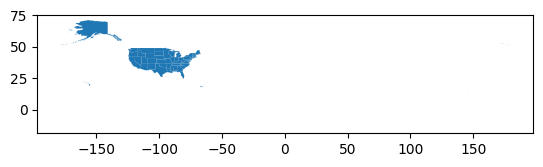

In [336]:
us_boundaries_gdf.plot()

<Axes: >

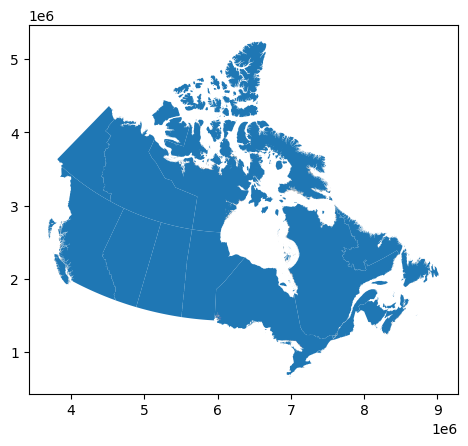

In [335]:
can_boundaries_gdf.plot()

## Définition de la zone d'étude

Notre zone d'étude est définie par un fichier geojson.

Pour le moment, ce fichier contient une géométrie centrée sur Montréal



In [ ]:
# urban_centers = ["Montreal"]
# # API Google to get the coordinate of the urban centers of our study
# 
# # Define a study zone englobing all the urban centers
#
# # Retrieve the data for the study zone

In [1]:
# Desired CRS
zone_crs = 'EPSG:4326'

# File containing the geometry of the study area
file_name = 'study_area.geojson'

In [2]:
# Load the geometry
zone_gdf = gpd.read_file(f'/content/{file_name}')

# Convert to the desired CRS
zone_gdf = zone_gdf.to_crs(zone_crs)

NameError: ignored

## Préparation des données propres à la zone d'étude

## Données administratives

In [ ]:
# Data with KML format
import fiona

# Data file
file_name = 'canvec_admin.kml'
file_location = f'{data_path}/{file_name}'

# Load kml file
gdf = gpd.read_file(file_location, driver='KML')

Explorer les données

0                 New Brunswick
1     Newfoundland and Labrador
2                      Manitoba
3                  Saskatchewan
4                        Quebec
5          Prince Edward Island
6                       Alberta
7              British Columbia
8                   Nova Scotia
9                       Ontario
10                        Yukon
11        Northwest Territories
12                      Nunavut
Name: Name, dtype: object


<Axes: >

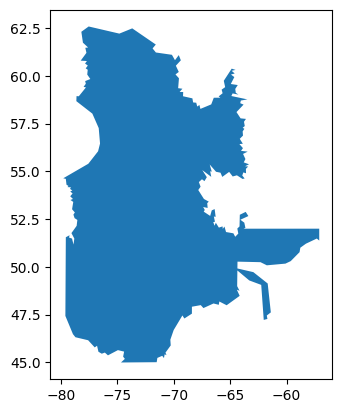

In [ ]:
# Lister les provinces
print(gdf['Name'])

# Show geometry for a Province in particular
gdf[gdf['Name']=='Quebec'].plot()

## Données matricielles de densité de population

Répartition de la population
*   Type: Carte matricielle (GeoTiff)
*   Couverture: mondiale
*   Date: 2020
*   Source: World Pop
*   Description: https://data.humdata.org/dataset/worldpop-population-counts-for-world
*   Fichier: https://data.worldpop.org/GIS/Population/Global_2000_2020/2020/0_Mosaicked/ppp_2020_1km_Aggregated.tif



In [ ]:
# Data file
file_name = 'ppp_2020_1km_Aggregated.tif'

# Load Data file
population_raster = rasterio.open(f'{data_path}/{file_name}')

# Show some info about the data
print(population_raster.profile)
print(population_raster.shape) # quelle est la taille de l'image ?
print(population_raster.count) # quel est le nombre de couches ?
print(population_raster.bounds) # quelle est l'enmprise de la couche dans son système de coordonnées ?
print(population_raster.crs) #... d'ailleurs, quel est son système de projection ?
print(population_raster.dtypes) # quel est le type des données des pixels de l'image ?
print(population_raster.width, population_raster.height) # Largeur, hauteur

# Convert to desired CRS
if population_raster.crs != zone_crs:
   population_raster.to_crs(zone_crs)

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -3.4028234663852886e+38, 'width': 43200, 'height': 18720, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.0083333333, 0.0, -180.001249265,
       0.0, -0.0083333333, 83.99958319871001), 'blockxsize': 256, 'blockysize': 256, 'tiled': True, 'compress': 'lzw', 'interleave': 'band'}
(18720, 43200)
1
BoundingBox(left=-180.001249265, bottom=-72.00041617728999, right=179.99874929500004, top=83.99958319871001)
EPSG:4326
('float32',)
43200 18720


In [ ]:
# Create a mask for RasterIO from the study zone
zone_mask = [json.loads(zone_gdf.to_json())['features'][0]['geometry']]

# clip raster
zone_population_raster = rasterio.mask.mask(population_raster, zone_mask, crop=True)

/usr/local/lib/python3.9/dist-packages/matplotlib/image.py:505: RuntimeWarning: overflow encountered in multiply
  A_resampled *= ((a_max - a_min) / frac)


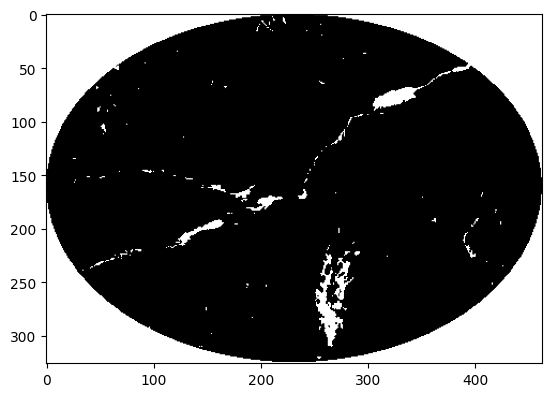

In [ ]:
# Show the data
plt.imshow(zone_population_raster[0][0], cmap='Greys')

In [ ]:
# Extract numPY array from raster
img_np = population_raster.read()

# Print some information about the array
print("Dimension de l'array :", img_np.shape)
print("La première bande :", img_np[0]) # pour accéder à la première bande
print("Les valeurs min et max des pixel de la bande :", img_np[0].min(), img_np.max()) # les valeurs minimale et maximale de la bande
print("La valeur du pixel central de la bande :", img_np[0, int(img_np[0].shape[0]/2), int(img_np[0].shape[1]/2)]) # pour accéder à tel ou tel pixel de la bande
print("La moyenne des pixels d'une bande :", np.mean(img_np[0][img_np[0] != 255])) # pour calculer des statistiques classiques sur la première bande
plt.imshow(img_np[0], cmap='Greys') # pour afficher une bande 

#plt.hist(np.histogram(img_np, bins=10, range=None, density=None, weights=None), bins='auto')

In [ ]:
x=len(zone_population_raster[0][0][0])
y=len(zone_population_raster[0][0])
print(f'x={x} y={y}')
print(len(zone_population_raster[0][0][0]))
print("Densite de population au km2 (centre de la carte):", zone_population_raster[0][0][int(y/2)][int(x/2)])

x=463 y=326
463
Densite de population au km2 (centre de la carte): 1475.3801
